# Neutron reflectometry use

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from reflectorch import EasyInferenceModel, interp_reflectivity

torch.manual_seed(0); # set seed for reproducibility

In this tutorial, we build upon the concepts introduced in the previous tutorial, where we demonstrated inference on XRR data, by highlighting key considerations specific to NR data.

## Handling linear resolution smearing

We consider the following NR data for a 1-layer stucture of Ni on Si (air as ambient), measured at a resolution dq/q = 0.1 (i.e. 10%):

In [66]:
data = np.loadtxt('../exp_data/Ni500.dat', delimiter='\t', skiprows=0)
print(data.shape)

q_exp = data[..., 0]
curve_exp = data[..., 1]
sigmas_exp = data[..., 2]

print(curve_exp.shape, q_exp.shape, q_exp.min(), q_exp.max())
print(sigmas_exp.shape, sigmas_exp.max(), sigmas_exp.min(), (sigmas_exp / curve_exp).max())

(174, 3)
(174,) (174,) 0.01333 0.22399
(174,) 8.83715e-05 4.23214e-07 0.3282606076124776


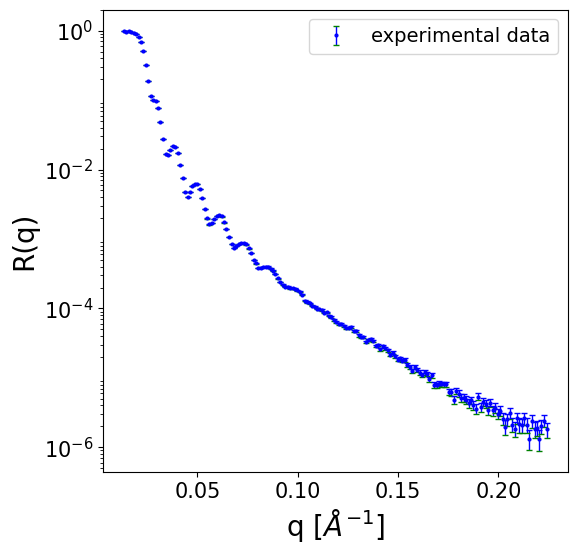

In [69]:
fig, ax = plt.subplots(1,1,figsize=(6,6))

ax.set_yscale('log')
ax.set_xlabel('q [$Å^{-1}$]', fontsize=20)
ax.set_ylabel('R(q)', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)

y_tick_locations = [10**(-2*i) for i in range(6)]
ax.yaxis.set_major_locator(plt.FixedLocator(y_tick_locations))

el = ax.errorbar(q_exp, curve_exp, fmt='o', markersize=2, linewidth=1,zorder=2,
                 yerr=sigmas_exp, xerr=None, color='blue', ecolor='blue', elinewidth=1, capsize=2, barsabove=False,
                 label='experimental data')
elines = el.get_children()
elines[1].set_color('green')

ax.legend(loc='upper right', fontsize=14)

We initialize an inference object for a model trained for neutron reflectometry and a standard parameterization with 1 layer (for more details on the `EasyInferenceModel` class see the previous tutorial):

In [78]:
config_name = 'b_mc_point_neutron_conv_standard_L1_InputQDq'

inference_model = EasyInferenceModel(config_name=config_name,
                                     device='cpu',
                                     )

Configuration file `D:\Github Projects\reflectorch\reflectorch\configs\b_mc_point_neutron_conv_standard_L1_InputQDq.yaml` found locally.
Weights file `D:\Github Projects\reflectorch\reflectorch\saved_models\model_b_mc_point_neutron_conv_standard_L1_InputQDq.safetensors` found locally.
Model b_mc_point_neutron_conv_standard_L1_InputQDq loaded. Number of parameters: 4.98 M
The model corresponds to a `standard_model` parameterization with 1 layers (5 predicted parameters)
Parameter types and total ranges:
- thicknesses: [1.0, 1000.0]
- roughnesses: [0.0, 60.0]
- slds: [-8.0, 16.0]
Allowed widths of the prior bound intervals (max-min):
- thicknesses: [0.01, 1000.0]
- roughnesses: [0.01, 60.0]
- slds: [0.01, 5.0]
The model was trained on curves discretized at exactly 128 uniform points, between q_min in [0.001, 0.03] and q_max in [0.1, 0.4]
The model was trained with linear resolution smearing (dq/q) in the range [0.01, 0.1]
The following quantities are additional inputs to the network: pri

We interpolate the data to a discretization suitable for this model:

In [79]:
q_model, exp_curve_interp = inference_model.interpolate_data_to_model_q(q_exp, curve_exp)

print(q_model.shape, q_model.min(), q_model.max())
print(exp_curve_interp.shape)

(128,) 0.01333 0.22399
(128,)


We set some prior bounds for the parameters:

In [82]:
prior_bounds = [(300., 900.), #layer thicknesses (top to bottom)
                (0., 20.), (0., 20.), #interlayer roughnesses (top to bottom)
                (9., 11.), (3., 5.)] #real layer slds: Ni, glass

For performing the prediction we need to provide the `q_resolution` argument. When this argument is a *float*, its meaning is dq/q. This value is always used for simulating the reflectivity curve corresponding to the predicted parameters and as a keyword argument to the reflectivity function during polishing. Depending on the training scenario, it might also be used as an additional input to the network.

In [83]:
prediction_dict = inference_model.predict(
    reflectivity_curve=exp_curve_interp,
    prior_bounds=prior_bounds,
    q_values=q_model,
    q_resolution=0.1,
    polish_prediction=True,
    calc_pred_curve=True,
    calc_pred_sld_profile=True,
    calc_polished_sld_profile=True,
)
print(prediction_dict.keys())


pred_params = prediction_dict['predicted_params_array']
pred_curve = prediction_dict['predicted_curve']

dict_keys(['predicted_params_object', 'predicted_params_array', 'param_names', 'predicted_curve', 'predicted_sld_profile', 'predicted_sld_xaxis', 'polished_params_array', 'polished_curve', 'sld_profile_polished'])


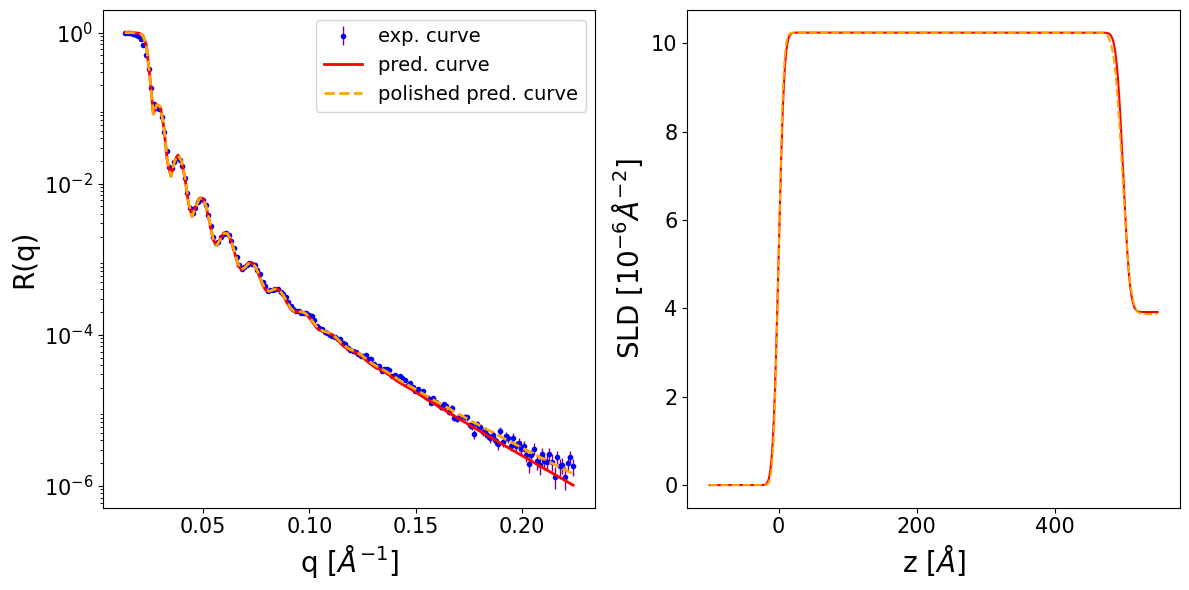

In [84]:
fig, ax = plt.subplots(1,2,figsize=(12,6))


ax[0].set_yscale('log')

ax[0].set_xlabel('q [$Å^{-1}$]', fontsize=20)
ax[0].set_ylabel('R(q)', fontsize=20)

ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[0].tick_params(axis='both', which='minor', labelsize=15)

y_tick_locations = [10**(-2*i) for i in range(6)]
ax[0].yaxis.set_major_locator(plt.FixedLocator(y_tick_locations))

el = ax[0].errorbar(q_exp, curve_exp, yerr=sigmas_exp, xerr=None, c='b', ecolor='purple', elinewidth=1, 
                 marker='o', linestyle='none', markersize=3, label='exp. curve', zorder=1)
elines = el.get_children()
elines[1].set_color('purple')

ax[0].plot(q_model, prediction_dict['predicted_curve'], c='red', lw=2, label='pred. curve')
ax[0].plot(q_model, prediction_dict['polished_curve'], c='orange', ls='--', lw=2, label='polished pred. curve')

handles, labels = ax[0].get_legend_handles_labels()
order = [2, 0, 1]
ax[0].legend(
    [handles[i] for i in order],
    [labels[i] for i in order],
    loc='upper right',
    fontsize=14
)

ax[1].set_xlabel('z [$Å$]', fontsize=20)
ax[1].set_ylabel('SLD [$10^{-6} Å^{-2}$]', fontsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=15)
ax[1].tick_params(axis='both', which='minor', labelsize=15)
ax[1].plot(prediction_dict['predicted_sld_xaxis'], prediction_dict['predicted_sld_profile'], c='red')
ax[1].plot(prediction_dict['predicted_sld_xaxis'], prediction_dict['sld_profile_polished'], c='orange', ls='--')


plt.tight_layout()


In [85]:
n_layers = inference_model.trainer.loader.prior_sampler.max_num_layers
for param_name, pred_param_val, polished_param_val in zip(prediction_dict["param_names"], pred_params, prediction_dict["polished_params_array"]):
        print(f'{param_name.ljust(14)} -> Predicted: {pred_param_val:.2f}       Polished: {polished_param_val:.2f}')

Thickness L1   -> Predicted: 498.53       Polished: 497.37
Roughness L1   -> Predicted: 6.45       Polished: 5.65
Roughness sub  -> Predicted: 7.68       Polished: 9.39
SLD L1         -> Predicted: 10.24       Polished: 10.24
SLD sub        -> Predicted: 3.92       Polished: 3.87


Next, we load data for a different measurement of a similar structure (also Ni on Si). The differences are that the Ni layer is thicker, the resolution is dq/q = 0.015 (i.e. 1.5 %) and the data has a constant background.

In [86]:
data = np.loadtxt('../exp_data/Ni_on_glass.dat', delimiter='\t', skiprows=0)
print(data.shape)

q_exp = data[..., 0]
curve_exp = data[..., 1]

print(curve_exp.shape, q_exp.shape, q_exp.min(), q_exp.max())


(757, 2)
(757,) (757,) 0.00508981 0.175655


We load a model which has the background as an additional predicted parameter:

In [87]:
config_name = 'e_mc_point_neutron_conv_standard_L1_InputQDq_n256_size1024'


inference_model = EasyInferenceModel(config_name=config_name,
                                     device='cpu',
                                     )

Configuration file `D:\Github Projects\reflectorch\reflectorch\configs\e_mc_point_neutron_conv_standard_L1_InputQDq_n256_size1024.yaml` found locally.
Weights file `D:\Github Projects\reflectorch\reflectorch\saved_models\model_e_mc_point_neutron_conv_standard_L1_InputQDq_n256_size1024.safetensors` found locally.
Model e_mc_point_neutron_conv_standard_L1_InputQDq_n256_size1024 loaded. Number of parameters: 20.24 M
The model corresponds to a `standard_model` parameterization with 1 layers (7 predicted parameters)
Parameter types and total ranges:
- thicknesses: [1.0, 1500.0]
- roughnesses: [0.0, 60.0]
- slds: [-8.0, 16.0]
- r_scale: [0.9, 1.1]
- log10_background: [-10.0, -4.0]
Allowed widths of the prior bound intervals (max-min):
- thicknesses: [0.01, 1500.0]
- roughnesses: [0.01, 60.0]
- slds: [0.01, 5.0]
- r_scale: [0.01, 0.2]
- log10_background: [0.01, 6.0]
The model was trained on curves discretized at exactly 256 uniform points, between q_min in [0.001, 0.02] and q_max in [0.05, 0.

In [89]:
prior_bounds = [
    (300., 900.), #layer thicknesses (top to bottom)
    (0., 20.), (0., 20.), #interlayer roughnesses (top to bottom)
    (9., 11.), (3., 5.), #layer slds: Ni, glass
    (0.9, 1.1), #intensity scaling factor
    (-10, -4), #log10 background
] 

In [90]:
q_model, exp_curve_interp = inference_model.interpolate_data_to_model_q(q_exp, curve_exp)

print(q_model.shape, q_model.min(), q_model.max())
print(exp_curve_interp.shape)

(256,) 0.00508981 0.175655
(256,)


Now we provide the new value of dq/q as argument:

In [91]:
prediction_dict = inference_model.predict(
    reflectivity_curve=exp_curve_interp,
    prior_bounds=prior_bounds,
    q_values=q_model,
    q_resolution=0.015,
    polish_prediction=True,
    calc_pred_curve=True,
    calc_pred_sld_profile=True,
    calc_polished_sld_profile=True,
)
print(prediction_dict.keys())


pred_params = prediction_dict['predicted_params_array']
pred_curve = prediction_dict['predicted_curve']

dict_keys(['predicted_params_object', 'predicted_params_array', 'param_names', 'predicted_curve', 'predicted_sld_profile', 'predicted_sld_xaxis', 'polished_params_array', 'polished_curve', 'sld_profile_polished'])


In [92]:
n_layers = inference_model.trainer.loader.prior_sampler.max_num_layers
for param_name, pred_param_val, polished_param_val in zip(prediction_dict["param_names"], pred_params, prediction_dict["polished_params_array"]):
        print(f'{param_name.ljust(14)} -> Predicted: {pred_param_val:.2f}       Polished: {polished_param_val:.2f}')

Thickness L1   -> Predicted: 812.66       Polished: 826.98
Roughness L1   -> Predicted: 8.42       Polished: 8.14
Roughness sub  -> Predicted: 1.35       Polished: 0.00
SLD L1         -> Predicted: 9.05       Polished: 9.17
SLD sub        -> Predicted: 3.85       Polished: 4.00
r_scale        -> Predicted: 0.97       Polished: 0.91
log10_background -> Predicted: -4.17       Polished: -4.00


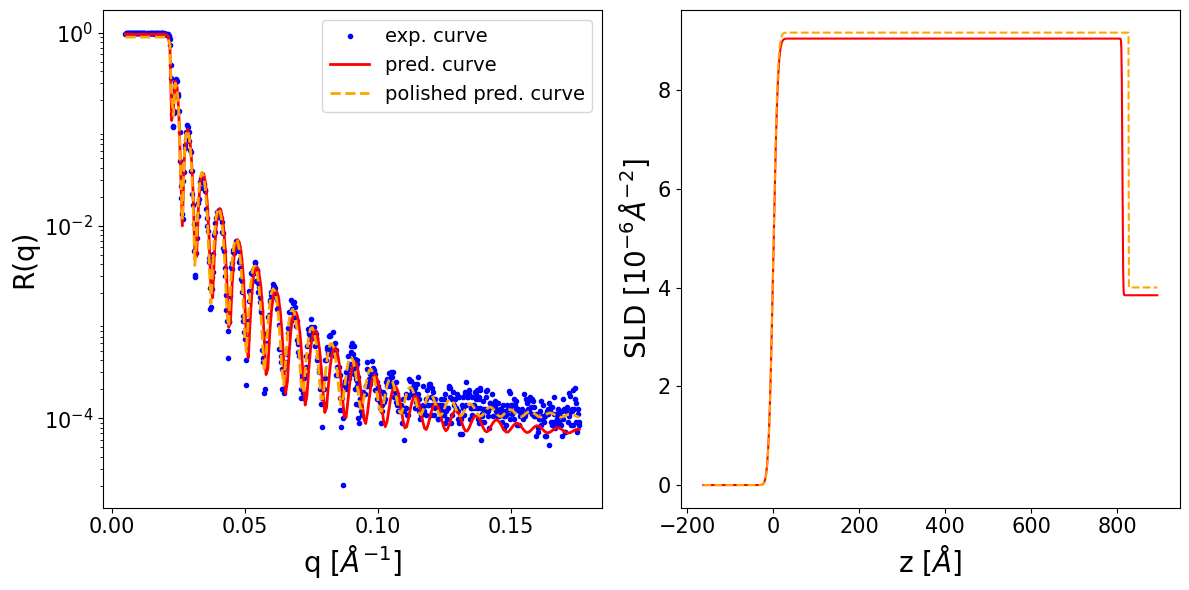

In [93]:
fig, ax = plt.subplots(1,2,figsize=(12,6))

ax[0].set_yscale('log')
ax[0].set_xlabel('q [$Å^{-1}$]', fontsize=20)
ax[0].set_ylabel('R(q)', fontsize=20)

ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[0].tick_params(axis='both', which='minor', labelsize=15)

y_tick_locations = [10**(-2*i) for i in range(6)]
ax[0].yaxis.set_major_locator(plt.FixedLocator(y_tick_locations))

el = ax[0].errorbar(q_exp, curve_exp, yerr=None, xerr=None, c='b', ecolor='purple', elinewidth=1, 
                 marker='o', linestyle='none', markersize=3, label='exp. curve', zorder=1)

ax[0].plot(q_model, prediction_dict['predicted_curve'], c='red', lw=2, label='pred. curve')
ax[0].plot(q_model, prediction_dict['polished_curve'], c='orange', ls='--', lw=2, label='polished pred. curve')

handles, labels = ax[0].get_legend_handles_labels()
order = [2, 0, 1]
ax[0].legend(
    [handles[i] for i in order],
    [labels[i] for i in order],
    loc='upper right',
    fontsize=14
)

ax[1].set_xlabel('z [$Å$]', fontsize=20)
ax[1].set_ylabel('SLD [$10^{-6} Å^{-2}$]', fontsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=15)
ax[1].tick_params(axis='both', which='minor', labelsize=15)
ax[1].plot(prediction_dict['predicted_sld_xaxis'], prediction_dict['predicted_sld_profile'], c='red')
ax[1].plot(prediction_dict['predicted_sld_xaxis'], prediction_dict['sld_profile_polished'], c='orange', ls='--')


plt.tight_layout()

## Handling pointwise resolution smearing

We load NR data of a thick silicon oxide layer on top of a silicon substrate. Notably the data is in 4 colums format [q, R, dR, dQ], the last column being the pointwise resolution smearing. We remove the last part of the curve which has high error bars.

In [167]:
data = np.loadtxt('../exp_data/D17_SiO.dat', skiprows=3)
print(data.shape)

max_point_no = 2050

q_exp = data[0:max_point_no, 0]
curve_exp = data[0:max_point_no, 1]
sigmas_exp = data[0:max_point_no, 2]
q_res_exp = data[0:max_point_no, 3]

print(curve_exp.shape, q_exp.shape, q_exp.min(), q_exp.max())
print(sigmas_exp.shape, sigmas_exp.max(), sigmas_exp.min(), (sigmas_exp / curve_exp).max())
print(q_res_exp.shape, (q_res_exp / q_exp).min(), (q_res_exp / q_exp).max())

(2166, 4)
(2050,) (2050,) 0.00610735 0.114432
(2050,) 1.39997 1.14757e-06 10.44030349303302
(2050,) 0.01295813163759255 0.019083468130430558


In [168]:
#conf_name = 'e_mc_point_neutron_conv_standard_L1_InputQDq_n128_size1024'
conf_name = 'e_mc_point_neutron_conv_standard_L1_InputQDq_n256_size1024'

inference_model = EasyInferenceModel(config_name=conf_name,
                                     device='cpu',
                                     )

Configuration file `D:\Github Projects\reflectorch\reflectorch\configs\e_mc_point_neutron_conv_standard_L1_InputQDq_n256_size1024.yaml` found locally.
Weights file `D:\Github Projects\reflectorch\reflectorch\saved_models\model_e_mc_point_neutron_conv_standard_L1_InputQDq_n256_size1024.safetensors` found locally.
Model e_mc_point_neutron_conv_standard_L1_InputQDq_n256_size1024 loaded. Number of parameters: 20.24 M
The model corresponds to a `standard_model` parameterization with 1 layers (7 predicted parameters)
Parameter types and total ranges:
- thicknesses: [1.0, 1500.0]
- roughnesses: [0.0, 60.0]
- slds: [-8.0, 16.0]
- r_scale: [0.9, 1.1]
- log10_background: [-10.0, -4.0]
Allowed widths of the prior bound intervals (max-min):
- thicknesses: [0.01, 1500.0]
- roughnesses: [0.01, 60.0]
- slds: [0.01, 5.0]
- r_scale: [0.01, 0.2]
- log10_background: [0.01, 6.0]
The model was trained on curves discretized at exactly 256 uniform points, between q_min in [0.001, 0.02] and q_max in [0.05, 0.

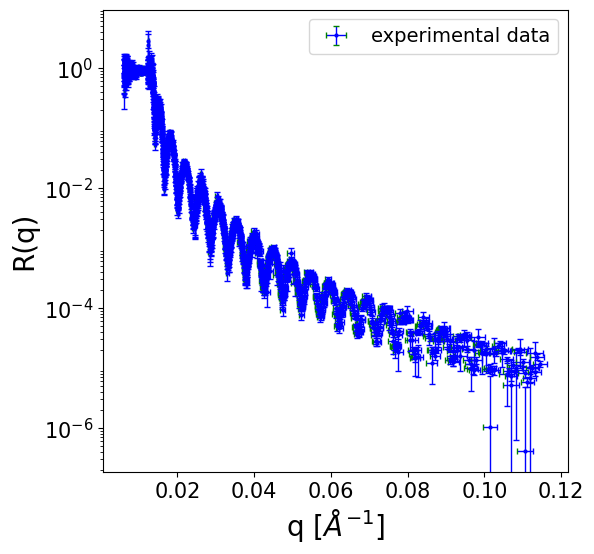

In [169]:
fig, ax = plt.subplots(1,1,figsize=(6,6))

ax.set_yscale('log')

ax.set_xlabel('q [$Å^{-1}$]', fontsize=20)
ax.set_ylabel('R(q)', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)

y_tick_locations = [10**(-2*i) for i in range(6)]
ax.yaxis.set_major_locator(plt.FixedLocator(y_tick_locations))

el = ax.errorbar(q_exp, curve_exp, fmt='o', markersize=2, linewidth=1,zorder=2,
                 yerr=sigmas_exp, xerr=q_res_exp, color='blue', ecolor='blue', elinewidth=1, capsize=2, barsabove=False,
                 label='experimental data')
elines = el.get_children()
elines[1].set_color('green')

ax.legend(loc='upper right', fontsize=14)

In [170]:
prior_bounds = [
    (500., 1500.), #layer thicknesses (top to bottom)
    (0., 30.), (0., 30.), #interlayer roughnesses (top to bottom)
    (3, 4), (1.7, 2.5), #layer slds (top to bottom)
    (0.9, 1.1), #intensity scaling factor
    (-10, -4), #log10 background
] 

In [171]:
q_model, exp_curve_interp = inference_model.interpolate_data_to_model_q(q_exp, curve_exp)

print(q_model.shape, q_model.min(), q_model.max())
print(exp_curve_interp.shape)

(256,) 0.00610735 0.114432
(256,)


Notably, here we have to also manually interpolate the q resolution array to the model grid. This will be provided as the `q_resolution` argument of the `predict` method.

In [172]:
q_res_interp = np.interp(q_model, q_exp, q_res_exp)
print(q_res_exp.shape, q_res_interp.shape, q_res_exp.shape, (q_res_interp / q_model).min(), (q_res_interp / q_model).max())

(2050,) (256,) (2050,) 0.012970237769559695 0.018944584008420546


In [173]:
prediction_dict = inference_model.predict(reflectivity_curve=exp_curve_interp,
                                          prior_bounds=prior_bounds,
                                          q_values=q_model,
                                          q_resolution=q_res_interp,
                                          clip_prediction=True,
                                          polish_prediction=True,
                                          calc_pred_curve=True,
                                          calc_pred_sld_profile=True,
                                          calc_polished_sld_profile=True,
                                          )
print(prediction_dict.keys())


pred_params = prediction_dict['predicted_params_array']
pred_curve = prediction_dict['predicted_curve']

dict_keys(['predicted_params_object', 'predicted_params_array', 'param_names', 'predicted_curve', 'predicted_sld_profile', 'predicted_sld_xaxis', 'polished_params_array', 'polished_curve', 'sld_profile_polished'])


In [175]:
n_layers = inference_model.trainer.loader.prior_sampler.max_num_layers
for param_name, pred_param_val, polished_param_val in zip(prediction_dict["param_names"], pred_params, prediction_dict["polished_params_array"]):
        print(f'{param_name.ljust(14)} -> Predicted: {pred_param_val:.2f}       Polished: {polished_param_val:.2f}')

Thickness L1   -> Predicted: 1209.83       Polished: 1245.83
Roughness L1   -> Predicted: 4.23       Polished: 5.94
Roughness sub  -> Predicted: 1.38       Polished: 9.35
SLD L1         -> Predicted: 3.39       Polished: 3.45
SLD sub        -> Predicted: 1.78       Polished: 2.09
r_scale        -> Predicted: 0.90       Polished: 1.02
log10_background -> Predicted: -10.00       Polished: -10.00


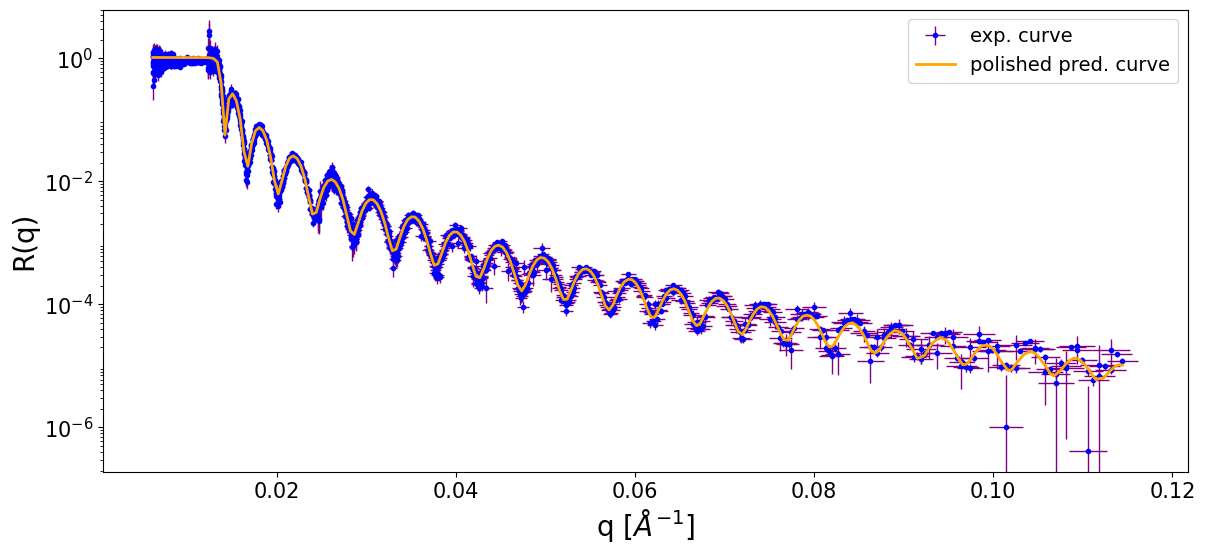

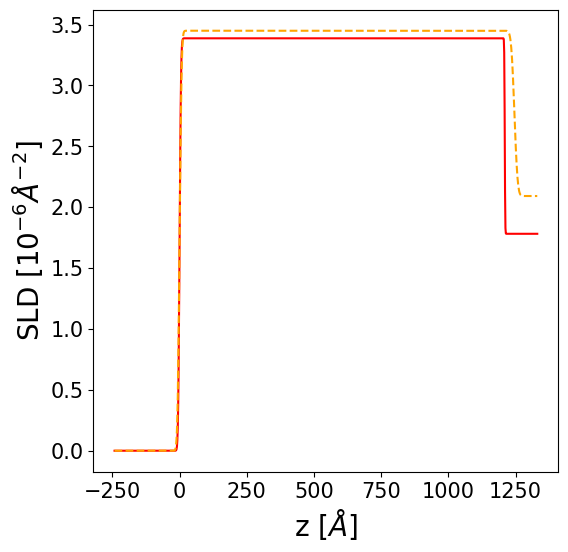

In [180]:
fig, ax = plt.subplots(1,1,figsize=(14,6))

ax.set_yscale('log')

ax.set_xlabel('q [$Å^{-1}$]', fontsize=20)
ax.set_ylabel('R(q)', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)

y_tick_locations = [10**(-2*i) for i in range(6)]
ax.yaxis.set_major_locator(plt.FixedLocator(y_tick_locations))

el = ax.errorbar(q_exp, curve_exp, yerr=sigmas_exp, xerr=q_res_exp, c='b', ecolor='purple', elinewidth=1, 
                 marker='o', linestyle='none', markersize=3, label='exp. curve', zorder=1)
elines = el.get_children()
elines[1].set_color('purple')

#ax.plot(q_model, pred_curve, c='red', lw=2, label='pred. curve', zorder=2)
ax.plot(q_model, prediction_dict['polished_curve'], c='orange', lw=2, label='polished pred. curve')

handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 0]

ax.legend([handles[i] for i in order], [labels[i] for i in order], loc='upper right', fontsize=14)


fig, ax = plt.subplots(1,1,figsize=(6,6))

ax.set_xlabel('z [$Å$]', fontsize=20)
ax.set_ylabel('SLD [$10^{-6} Å^{-2}$]', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.plot(prediction_dict['predicted_sld_xaxis'], prediction_dict['predicted_sld_profile'], c='red')
ax.plot(prediction_dict['predicted_sld_xaxis'], prediction_dict['sld_profile_polished'], c='orange', ls='--')

## Structures with ambient medium (fronting) different than air

We load neutron reflectometry (NR) data for a multilayer structure composed of silicon/silicon oxide/polymer/D₂O. Notably, the ambient medium in this case is not air, meaning the ambient SLD is non-zero. Although all models in Reflectorch are trained assuming an ambient SLD of zero, inference on data with non-zero ambient SLD is still valid. This is due to the invariance property of reflectivity under uniform SLD shifts, where R(SLD(z)) = R(SLD(z)+A) for any constant A.

In [189]:
data = np.loadtxt('../exp_data/ORSO_example.ort')
print(data.shape)

max_point_no = 350 #remove part of the data with high error bars

q_exp = data[0:max_point_no, 0]
curve_exp = data[0:max_point_no, 1]
sigmas_exp = data[0:max_point_no, 2]
q_res_exp = data[0:max_point_no, 3]

print(curve_exp.shape, q_exp.shape, q_exp.min(), q_exp.max())
print(sigmas_exp.shape, sigmas_exp.max(), sigmas_exp.min(), (sigmas_exp / curve_exp).max())
print(q_res_exp.shape, (q_res_exp / q_exp).min(), (q_res_exp / q_exp).max())

(408, 4)
(350,) (350,) 0.00806022 0.26145
(350,) 0.125959 1.19257e-07 0.2542693029005862
(350,) 0.017461305621930916 0.018550916324345


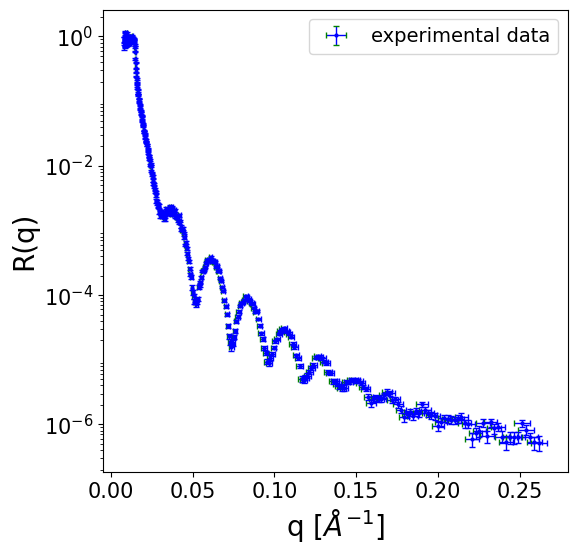

In [190]:
fig, ax = plt.subplots(1,1,figsize=(6,6))

ax.set_yscale('log')

ax.set_xlabel('q [$Å^{-1}$]', fontsize=20)
ax.set_ylabel('R(q)', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)

y_tick_locations = [10**(-2*i) for i in range(6)]
ax.yaxis.set_major_locator(plt.FixedLocator(y_tick_locations))

el = ax.errorbar(q_exp, curve_exp, fmt='o', markersize=2, linewidth=1,zorder=2,
                 yerr=sigmas_exp, xerr=q_res_exp, color='blue', ecolor='blue', elinewidth=1, capsize=2, barsabove=False,
                 label='experimental data')
elines = el.get_children()
elines[1].set_color('green')

ax.legend(loc='upper right', fontsize=14)

In [191]:
config_name = "b_mc_point_neutron_conv_standard_L2_InputQDq"
inference_model = EasyInferenceModel(config_name=config_name,
                                     device='cpu',
                                     )

Configuration file `D:\Github Projects\reflectorch\reflectorch\configs\b_mc_point_neutron_conv_standard_L2_InputQDq.yaml` found locally.
Weights file `D:\Github Projects\reflectorch\reflectorch\saved_models\model_b_mc_point_neutron_conv_standard_L2_InputQDq.safetensors` found locally.
Model b_mc_point_neutron_conv_standard_L2_InputQDq loaded. Number of parameters: 5.04 M
The model corresponds to a `standard_model` parameterization with 2 layers (8 predicted parameters)
Parameter types and total ranges:
- thicknesses: [1.0, 500.0]
- roughnesses: [0.0, 60.0]
- slds: [-8.0, 16.0]
Allowed widths of the prior bound intervals (max-min):
- thicknesses: [0.01, 500.0]
- roughnesses: [0.01, 60.0]
- slds: [0.01, 5.0]
The model was trained on curves discretized at exactly 128 uniform points, between q_min in [0.001, 0.03] and q_max in [0.1, 0.4]
The model was trained with linear resolution smearing (dq/q) in the range [0.01, 0.1]
The following quantities are additional inputs to the network: prior

In [193]:
prior_bounds = [(10., 40.), (50., 500.), #layer thicknesses: SiOx, polymer
                (1.0, 20.0), (1.0, 20.0), (1.0, 20.0), #interlayer roughnesses: Si/SiOx, SiOx/polymer, polymer/D2O
                (2.5, 4.0), (1., 5.), (6.3, 6.4)] #layer slds: SiOx, polymer, D2O

In [194]:
q_model, exp_curve_interp = inference_model.interpolate_data_to_model_q(q_exp, curve_exp)

print(q_model.shape, q_model.min(), q_model.max())
print(exp_curve_interp.shape)

(128,) 0.00806022 0.26145
(128,)


In [196]:
q_res_interp = np.interp(q_model, q_exp, q_res_exp) #pointwise resolution smearing
print(q_res_exp.shape, q_res_interp.shape, q_res_exp.shape, (q_res_interp / q_model).min(), (q_res_interp / q_model).max())

(350,) (128,) (350,) 0.017461305621930916 0.018550916324345


For inference we need to additionally provide the SLD of the ambient medium (here silicon) as the `ambient_sld` argument of the `predict` method:

In [197]:
prediction_dict = inference_model.predict(reflectivity_curve=exp_curve_interp,
                                          prior_bounds=prior_bounds,
                                          q_values=q_model,
                                          q_resolution=q_res_interp,
                                          ambient_sld=2.07, #Si
                                          clip_prediction=False,
                                          polish_prediction=True,
                                          calc_pred_curve=True,
                                          calc_pred_sld_profile=True,
                                          calc_polished_sld_profile=True
                                          )
print(prediction_dict.keys())


pred_params = prediction_dict['predicted_params_array']
pred_curve = prediction_dict['predicted_curve']

dict_keys(['predicted_params_object', 'predicted_params_array', 'param_names', 'predicted_curve', 'predicted_sld_profile', 'predicted_sld_xaxis', 'polished_params_array', 'polished_curve', 'sld_profile_polished'])


In [198]:
n_layers = inference_model.trainer.loader.prior_sampler.max_num_layers
for param_name, pred_param_val, polished_param_val in zip(prediction_dict["param_names"], pred_params, prediction_dict["polished_params_array"]):
        print(f'{param_name.ljust(14)} -> Predicted: {pred_param_val:.2f}       Polished: {polished_param_val:.2f}')

Thickness L2   -> Predicted: 38.21       Polished: 37.31
Thickness L1   -> Predicted: 255.88       Polished: 259.63
Roughness L2   -> Predicted: 7.65       Polished: 8.07
Roughness L1   -> Predicted: 12.62       Polished: 9.83
Roughness sub  -> Predicted: 3.17       Polished: 1.00
SLD L2         -> Predicted: 3.57       Polished: 3.56
SLD L1         -> Predicted: 2.34       Polished: 2.61
SLD sub        -> Predicted: 6.36       Polished: 6.30


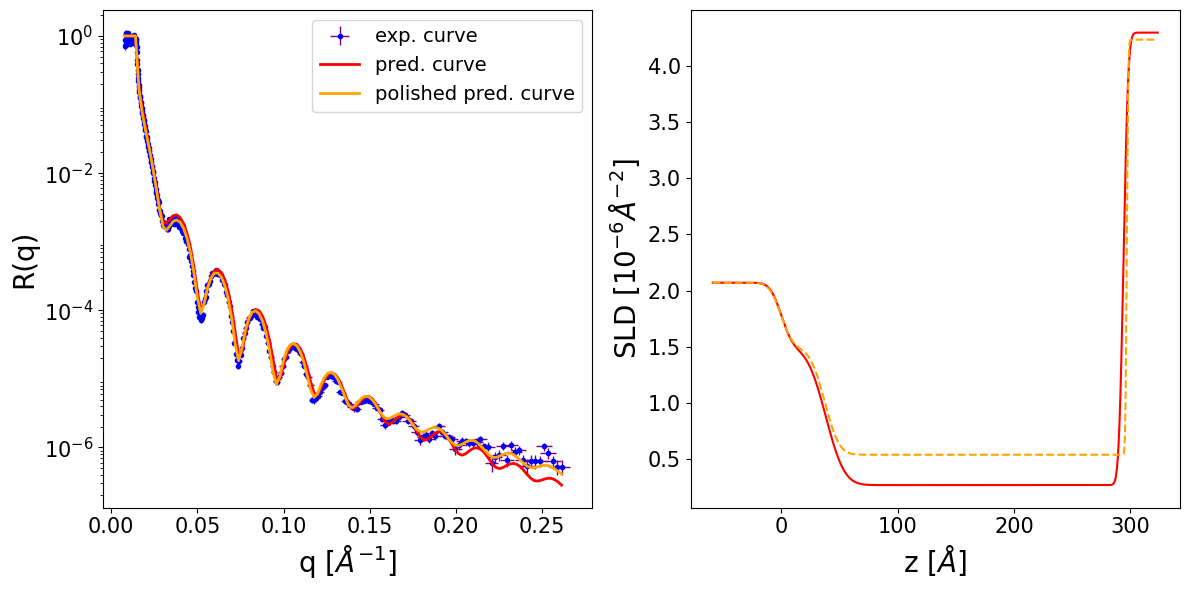

In [199]:
fig, ax = plt.subplots(1,2,figsize=(12,6))

ax[0].set_yscale('log')

ax[0].set_xlabel('q [$Å^{-1}$]', fontsize=20)
ax[0].set_ylabel('R(q)', fontsize=20)

ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[0].tick_params(axis='both', which='minor', labelsize=15)

y_tick_locations = [10**(-2*i) for i in range(6)]
ax[0].yaxis.set_major_locator(plt.FixedLocator(y_tick_locations))

el = ax[0].errorbar(q_exp, curve_exp, yerr=sigmas_exp, xerr=q_res_exp, c='b', ecolor='purple', elinewidth=1, 
                 marker='o', linestyle='none', markersize=3, label='exp. curve', zorder=1)
elines = el.get_children()
elines[1].set_color('purple')

ax[0].plot(q_model, pred_curve, c='red', lw=2, label='pred. curve', zorder=2)
ax[0].plot(q_model, prediction_dict['polished_curve'], c='orange', lw=2, label='polished pred. curve')

handles, labels = ax[0].get_legend_handles_labels()
order = [2, 0, 1]

ax[0].legend([handles[i] for i in order], [labels[i] for i in order], loc='upper right', fontsize=14)

ax[1].set_xlabel('z [$Å$]', fontsize=20)
ax[1].set_ylabel('SLD [$10^{-6} Å^{-2}$]', fontsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=15)
ax[1].tick_params(axis='both', which='minor', labelsize=15)
ax[1].plot(prediction_dict['predicted_sld_xaxis'], prediction_dict['predicted_sld_profile'], c='red')
ax[1].plot(prediction_dict['predicted_sld_xaxis'], prediction_dict['sld_profile_polished'], c='orange', ls='--')


plt.tight_layout()